In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

# Latin Hypercube Designs

Latin hyper-cube designs (LHS) are quasi-random sequences that resemble uniform random numbers, but have better convergence properties than truly random numbers.

+ A **latin square** is a square grid containing samples only one sample in each row and each column.
+ A **latin hypercube** is the generalization of this concept to many dimensions.

Here is how they look like in 2D.

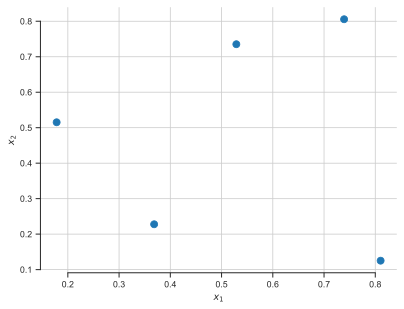

In [20]:
import scipy.stats.qmc as qmc
import numpy as np

# Define the number of dimensions and samples
dim = 2
num_samples = 5

# Create a Latin Hypercube sampler with the given dimensions
sampler = qmc.LatinHypercube(dim)

# Generate the samples (between 0 and 1)
X = sampler.random(n=num_samples)

# Plotting
fig, ax = plt.subplots()
ax.grid(which='major')
# Scatter plot for the Latin Hypercube samples
ax.scatter(X[:, 0], X[:, 1], 50., color=sns.color_palette()[0])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
sns.despine(trim=True)

We can compare this to uniform samples in 2D.

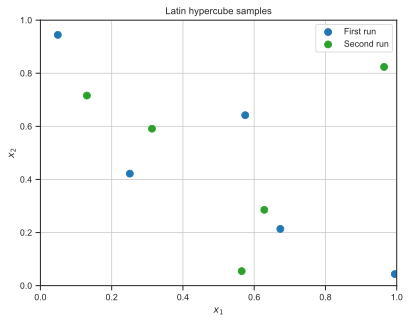

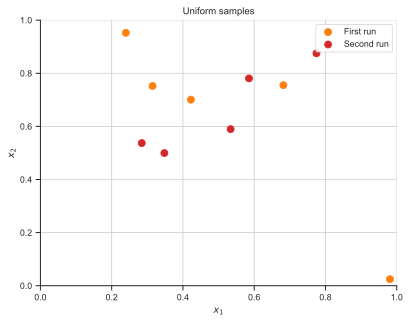

In [21]:
# Number of samples
num_samples = 5

# Latin Hypercube Sampling
fig, ax = plt.subplots()
sampler = qmc.LatinHypercube(d=2)

# First set of LHS samples
X_lhs = sampler.random(n=num_samples)
ax.scatter(X_lhs[:, 0], 
           X_lhs[:, 1], 
           50., 
           color=sns.color_palette()[0], 
           label='First run')

# Second set of LHS samples (resetting sampler for a new set)
sampler = qmc.LatinHypercube(d=2)
X_lhs = sampler.random(n=num_samples)
ax.grid(which='major')
ax.scatter(X_lhs[:, 0], 
           X_lhs[:, 1], 
           50., 
           color=sns.color_palette()[2], 
           label='Second run')

# Set title and labels for LHS plot
ax.set_title('Latin hypercube samples')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.legend()

# Uniform Sampling for comparison
fig2, ax2 = plt.subplots()
X_unif = np.random.rand(num_samples, 2)

# First set of uniform samples
ax2.grid(which='major')
ax2.scatter(X_unif[:, 0], 
            X_unif[:, 1], 
            50., 
            color=sns.color_palette()[1],
            label='First run')

# Second set of uniform samples
X_unif = np.random.rand(num_samples, 2)
ax2.scatter(X_unif[:, 0], 
            X_unif[:, 1], 
            50., 
            color=sns.color_palette()[3], 
            label='Second run')

# Set title and labels for uniform plot
ax2.set_title('Uniform samples')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.legend()
sns.despine(trim=True)

## Uniform Sampling vs Latin Hyper-cubes
Consider the ODE:

$$
\dot{y} = \frac{d y(t)}{dt} =-ay(t)
$$

$$
y(0) = y_0
$$

The solution is: $y(t) = Ie^{-at}$.
Let's make $a$ and $I$ random and use MC and LHS to find the mean, $E[y(t)]$, and the variance $V[y(t)]$.
We'll take:

$$
a \sim \mathcal{U}(0, 0.1),
$$

and

$$
y_0 \sim \mathcal{U}(8, 10).
$$

For convenience, let's map these random variables to standardized uniform random variables:

$$
x_i \sim \mathcal{U}(0, 1), \qquad i=1,2.
$$

This can be done by defining:

$$
a = 0.1 x_1.
$$

Using the new random variables, the ODE can be written as:

$$
\dot{y} = -0.1 x_1 y
$$

$$
y(0) = 8 + 2x_2.
$$

### The "Solver" object
Let's develop a solver for this problem. We'll make the solver work as a nice function that accepts a vector $\mathbf{x} = (x_1, x_2)$ as an input, and returns the solution of the ODE on a finite set of time-steps: 

$0=t_1<t_2<\dots<t_{n_t}=T$. 

The solver, will make use of the functionality of [scipy.integrate.odeint](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html).

In [22]:
import scipy.integrate

# Define the ODE solver class
class Ex1Solver(object):
    """
    An object that can solver the aforementioned ODE problem.
    It will work just like a multivariate function.
    """
    
    def __init__(self, nt=100, T=5):
        """
        This is the initializer of the class.
        
        Arguments:
            nt - The number of time-steps.
            T  - The final time.
        """
        self.nt = nt
        self.T = T
        self.t = np.linspace(0, T, nt) # The time-steps on which we will get the solution
        # The following are not essential, but they are convenient
        self.num_input = 2             # The number of inputs the class accepts
        self.num_output = nt           # The number of outputs the class returns
    
    def __call__(self, x):
        """
        This special class method emulates a function call.
        
        Arguments:
            x - A 1D numpy array with 2 elements. This represents the stochastic input x = (x1, x2).
        """
        def rhs(y, t, x1):
            """
            This is the right hand side of the ODE.
            """
            return -.1 * x1 * y
        # The initial condition
        y0 = [8 + 2 * x[1]]
        # We are ready to solve the ODE
        y = scipy.integrate.odeint(rhs, y0, self.t, args=(x[0],)).flatten()
        # The only strange thing here is the use of ``args`` to pass they x1 argument to the rhs().
        return y

In [23]:
# Instantiate the solver
solver = Ex1Solver(nt=200, T=50)

# Now let's evaluate the solver at a specific input.
x = [0.5, 0.5]
y = solver(x)
print(y)

[9.         8.88764176 8.77668666 8.66711647 8.55891419 8.45206273
 8.34654522 8.24234502 8.13944568 8.03783094 7.9374848  7.8383914
 7.74053511 7.64390048 7.54847226 7.45423538 7.36117497 7.26927633
 7.17852497 7.08890658 7.00040701 6.91301231 6.82670868 6.7414825
 6.6573203  6.57420881 6.49213489 6.41108558 6.3310481  6.25200982
 6.17395828 6.09688115 6.02076628 5.94560164 5.87137538 5.79807577
 5.72569126 5.65421041 5.58362194 5.51391471 5.44507772 5.37710012
 5.30997115 5.24368025 5.17821693 5.11357087 5.04973187 4.98668985
 4.92443486 4.86295708 4.8022468  4.74229444 4.68309054 4.62462576
 4.56689086 4.50987674 4.4535744  4.39797495 4.34306962 4.28884974
 4.23530676 4.18243223 4.13021781 4.07865524 4.02773638 3.97745321
 3.92779777 3.87876223 3.83033886 3.78252001 3.73529813 3.68866578
 3.6426156  3.59714032 3.55223278 3.50788589 3.46409264 3.42084611
 3.37813949 3.33596603 3.29431907 3.25319203 3.21257843 3.17247185
 3.13286597 3.09375454 3.05513139 3.01699042 2.97932561 2.942131

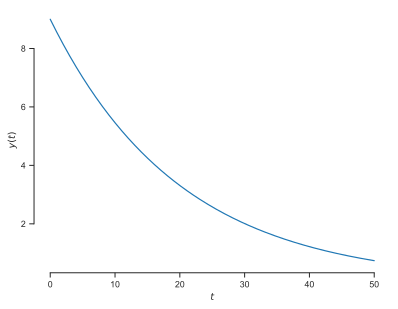

In [24]:
# Let's plot it:
fig, ax = plt.subplots()
ax.plot(solver.t, y)
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$')
sns.despine(trim=True)

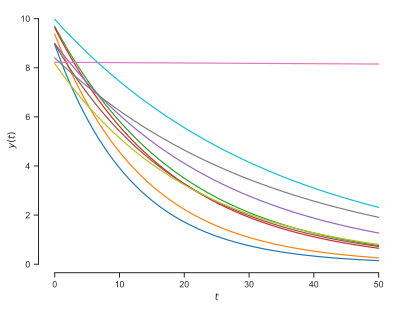

In [25]:
# Now, let's just plot a few random samples.
fig, ax = plt.subplots()
for i in range(10):
    x = np.random.rand(2)
    y = solver(x)
    plt.plot(solver.t, y)
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$')
sns.despine(trim=True)

### Propagating Uncertainties with LHS

Let's propagate the uncertainties through the ODE using LHS.

In [26]:
# Initialize outputs
y_lhs = np.zeros(solver.num_output)  # Sum of outputs
y2_lhs = np.zeros(solver.num_output)  # Sum of squares of outputs

# Number of samples
num_samples = 10000

# Create the LHS design using scipy.stats.qmc
sampler = qmc.LatinHypercube(d=2)  # Assuming 2 dimensions, adjust `d` as needed
X = sampler.random(n=num_samples)  # Generate the LHS samples

# To store the results
data_lhs = []

# Loop through the samples
for i in range(num_samples):
    if i % 1000 == 0:
        print('sample', i + 1, 'from', num_samples)
    x = X[i, :]
    y = solver(x)  # Assuming solver returns a numpy array of outputs
    y_lhs += y  # Sum of outputs
    y2_lhs += y ** 2  # Sum of squares of outputs
    data_lhs.append(y)  # Store the output

# Convert the accumulated results into a numpy array
data_lhs = np.array(data_lhs)

# Compute the mean estimate
y_m_lhs = y_lhs / num_samples

# Compute the variance estimate
y_v_lhs = y2_lhs / num_samples - y_m_lhs ** 2

sample 1 from 10000
sample 1001 from 10000
sample 2001 from 10000
sample 3001 from 10000
sample 4001 from 10000
sample 5001 from 10000
sample 6001 from 10000
sample 7001 from 10000
sample 8001 from 10000
sample 9001 from 10000


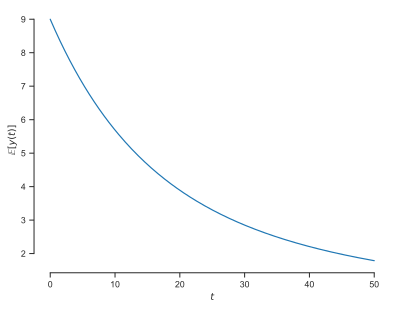

In [27]:
# Let's plot the mean
plt.plot(solver.t, y_m_lhs)
plt.xlabel('$t$')
plt.ylabel('$\mathbb{E}[y(t)]$')
sns.despine(trim=True)

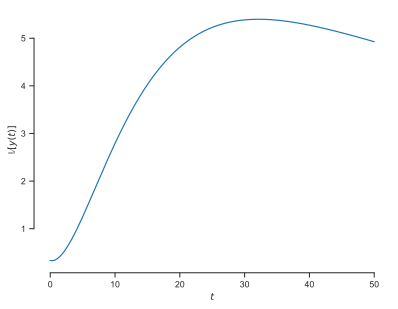

In [28]:
# Let's plot the variance
plt.plot(solver.t, y_v_lhs)
plt.xlabel('$t$')
plt.ylabel('$\mathbb{V}[y(t)]$')
sns.despine(trim=True)

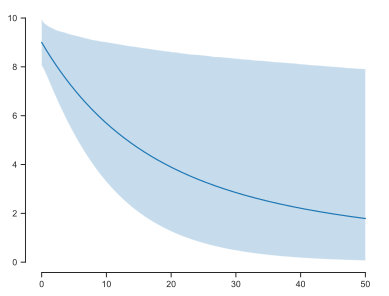

In [29]:
# Now, let's draw the predictive envelop
# We need the standard deviation:
y_s_lhs = np.sqrt(y_v_lhs)
y_l_lhs = np.percentile(data_lhs, 2.75, axis=0)
# An upper bound for the prediction
y_u_lhs = np.percentile(data_lhs, 97.5, axis=0)
# And let's plot it:
plt.plot(solver.t, y_m_lhs)
plt.fill_between(solver.t, y_l_lhs, y_u_lhs, alpha=0.25)
sns.despine(trim=True)

## Evaluating the Performance of LHS

To test this, we need to establish a ground truth.
Fortunately, we can get an analytic solution to:

$$
\dot{y} = -0.1 x_1 y
$$

$$
y(0) = 8 + 2x_2.
$$

It is:

$$
y(t;x_1,x_2) = (8 + 2x_2)e^{-0.1 x_1 t}.
$$

We can integrate $x_1$ and $x_2$ analytically from this expression.

Doing so, we get the following mean solution and variance:

$$
\mu = \mathbb{E}[y] = \frac{90}{t} (1 - \exp^{-0.1t})
$$

$$
\mathrm{S} = \mathbb{V}[y] =  \frac{2440}{6t}(1 - \exp^{-0.2t}) - \mu^2
$$

In [30]:
# Define a function to compute the expected value of the output at time t
def E_y(t):
    """
    The expected value of the output at time t.

    Arguments:
        t - The time at which we want to evaluate the expected value.

    Returns:
        The expected value of the output at time t.
    """
    if t == 0:
        return 9.
    return (90*(1-np.exp(-0.1*t))) / t
E_y =  np.vectorize(E_y)

# Define a function to compute the variance of the output at time t
def V_y(t):
    """
    The variance of the output at time t.

    Arguments:
        t - The time at which we want to evaluate the variance.

    Returns:
        The variance of the output at time t.
    """
    if t == 0:
        return (2440*0.2)/6. - E_y(t) **2
    
    return (2440.*(1-np.exp(-0.2*t)))/(6.*t) - E_y(t)**2
V_y = np.vectorize(V_y)

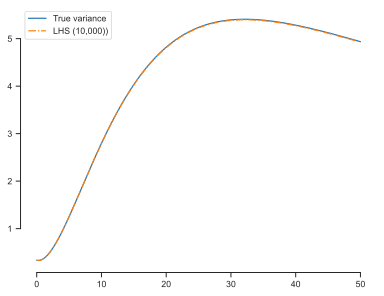

In [31]:
# Do some plots that compare the variance obtained by LHS to the true one
plt.plot(solver.t, V_y(solver.t), label='True variance')
plt.plot(solver.t, y_v_lhs, '-.', label='LHS (10,000))')
plt.legend(loc='best')
sns.despine(trim=True)

It seems close. But this is for 10,000 samples.
Let's test the convergence of Latin Hypercube compared to uniform sampling. To do this, we will compute the evolution of the root square error in the variance:

$$
{RSE}_\alpha(n) = \left(\sum_{i=1}^{n_t}\left(V[y(t_i)] - V_{\alpha,n}[y(t_i)]\right)^2\right)^{\frac{1}{2}},
$$

where $n$ is the number of samples used, and $V_{\alpha,n}[y(t_i)]$ is the estimate of the variance of $y(t_i)$.
It will probably take a while to develop the code.

In [32]:
# Function to compute the RSE for uniform sampling
def get_MC_rse(max_num_samples=100):
    """
    Get the maximum error of MC.
    """
    y_v_true = V_y(solver.t)
    y = np.zeros(solver.num_output)
    y2 = np.zeros(solver.num_output)
    n = []
    rse = []
    for i in range(max_num_samples):
        x = np.random.rand(2)
        y_sample = solver(x)
        y += y_sample
        y2 += y_sample ** 2
        if i % 1 == 0:    # Produce estimate every 100 steps
            n.append(i + 1)
            y_m = y / (i + 1)
            y_v = y2 / (i + 1) - y_m ** 2
            rse.append(np.linalg.norm(y_v_true - y_v))
    return n, rse


# Helper function to compute the RSE over increasing number of samples
def _get_LHS_rse(max_num_samples=100):
    """
    This function will compute the RSE over increasing number of samples.

    Arguments:
        max_num_samples - The maximum number of samples to use.

    Returns:
        n - A list of sample counts.
        rse - A list of RSE values.
    """
    # True variance of the solver output
    y_v_true = V_y(solver.t)
    
    # Initialize accumulators
    y = np.zeros(solver.num_output)
    y2 = np.zeros(solver.num_output)
    
    # Lists to store the sample counts and RSE
    n = []
    rse = []
    
    # Create the LHS design using scipy.stats.qmc
    sampler = qmc.LatinHypercube(d=2)
    X = sampler.random(n=max_num_samples)  # Generate Latin Hypercube samples
    
    # Loop through the samples
    for i in range(max_num_samples):
        x = X[i, :]
        y_sample = solver(x)
        y += y_sample
        y2 += y_sample ** 2
        
        # Compute RSE at every step
        if i % 1 == 0:    # Update every step (can adjust to 100 for less frequent updates)
            n.append(i + 1)
            y_m = y / (i + 1)
            y_v = y2 / (i + 1) - y_m ** 2
            rse.append(np.linalg.norm(y_v_true - y_v))  # Compute relative standard error (RSE)
    
    return n, rse

# Function to compute RSE for LHS
def get_LHS_rse(max_num_samples=100):
    """
    This function will compute the RSE over increasing number of samples.

    Arguments:
        max_num_samples - The maximum number of samples to use.

    Returns:
        n - A list of sample counts.
        rse - A list of RSE values.
    """
    # Initialize lists for storing sample count and RSE
    n = []
    rse = []
    
    # Loop through to get RSE over increasing number of samples
    for i in range(max_num_samples):
        if i % 1 == 0:  # Adjust here to control how often the RSE is computed
            _n, _rse = _get_LHS_rse(i + 1)
            n.append(_n[-1])
            rse.append(_rse[-1])
    
    return n, rse

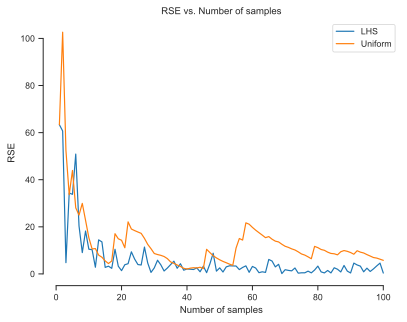

In [33]:
# Plot the RSE vs. number of samples
fig, ax = plt.subplots()
n, rse = get_LHS_rse(100)
n_mc, rse_mc = get_MC_rse(100)
ax.plot(n, rse, label='LHS')
ax.plot(n_mc, rse_mc, label='Uniform')
ax.set_xlabel('Number of samples')
ax.set_ylabel('RSE')
ax.set_title('RSE vs. Number of samples')
ax.legend()
sns.despine(trim=True)

You can see Latin Hypercube converges quicker than uniform sampling, but there is a considerable amount of epistemic uncertainty.
How would you go about quantifying it?
Notice, that every time you run the above code, it produces a different estimate. This suggests, that if you repeat the procedure, say 100 times, you will be able to get predictive error bars for the error!

In [34]:
# Set up Monte Carlo simulation
num_exper = 100
num_samples = 20
rse_lhs_samples = []
rse_mc_samples = []


for i in range(num_exper):
    n_lhs, rse_lhs = get_LHS_rse(num_samples)
    rse_lhs_samples.append(rse_lhs)
    n_mc, rse_mc = get_MC_rse(num_samples)
    rse_mc_samples.append(rse_mc)

rse_lhs_samples = np.array(rse_lhs_samples)
rse_mc_samples = np.array(rse_mc_samples)

# Compute the statistics for LHS
rse_lhs_m = np.mean(rse_lhs_samples, axis=0)
rse_lhs_l = np.percentile(rse_lhs_samples, 2.75, axis=0)
rse_lhs_u = np.percentile(rse_lhs_samples, 97.5, axis=0)

# Compute the statistics for uniform sampling
rse_mc_m = np.mean(rse_mc_samples, axis=0)
rse_mc_l = np.percentile(rse_mc_samples, 2.75, axis=0)
rse_mc_u = np.percentile(rse_mc_samples, 97.5, axis=0)

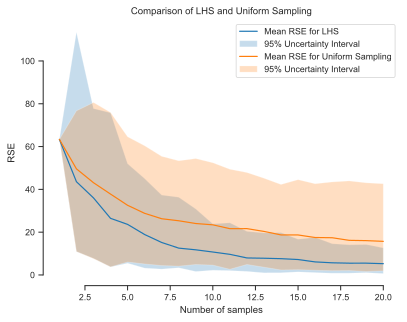

In [35]:
fig, ax = plt.subplots()
ax.plot(n_lhs, rse_lhs_m, label='Mean RSE for LHS')
ax.fill_between(n_lhs, rse_lhs_l, rse_lhs_u, alpha=0.25, label='95% Uncertainty Interval')
ax.plot(n_mc, rse_mc_m, label='Mean RSE for Uniform Sampling')
ax.fill_between(n_mc, rse_mc_l, rse_mc_u, alpha=0.25, label='95% Uncertainty Interval')
ax.set_xlabel('Number of samples')
ax.set_ylabel('RSE')
ax.set_title('Comparison of LHS and Uniform Sampling')
ax.legend()
sns.despine(trim=True)

Now you can see how much more accurage Latin Hypercube is compared to uniform sampling!